In [9]:
#!pip install bing-image-downloader
#!pip install keras-tuner --upgrade

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from bing_image_downloader import downloader
import keras_tuner as kt

RANDOM_STATE = 22

IMG_ROWS = 224
IMG_COLS = 224
CHANNELS = 3

INPUT_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)

## Import the WEAPD Dataset

In [ ]:
#!wget https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/M8JQCR#
#!unzip dataset

In [2]:
path = 'dataset' 
images_directories = os.listdir(path)

images_directories.remove('.DS_Store')
images_directories

['lightning',
 'sandstorm',
 'glaze',
 'rain',
 'rime',
 'frost',
 'fogsmog',
 'hail',
 'dew',
 'rainbow',
 'snow']

For the dataset we consider 'jpg' as almost all samples are in this format, this way we can exclude other formats such as 'gif' and other animated formats.

In [2]:
def get_dataset(images_directories):
    '''
    This method creates a unified version of the dataset to store in a tensor as well retreiving the labels per each sample.
    The images are loaded from the given subdirectories. The images are resized to a fixed size and normalized to the range [0, 1]. 

    Args:
        images_directories (list of str): A list of subdirectories, each corresponds to a label folder. 

    Returns:
        images_tensor (tf.Tensor): A tensor of shape (N, IMG_ROWS, IMG_COLS, 3) where N is the number of images, IMG_ROWS and IMG_COLS are the dimensions the images are resized to, 
                                        and 3 corresponds to the RGB channels.
        labels (list of str): A list of labels corresponding to the images. Each label corresponds to the name of the subdirectory from which the images are taken.

    '''

    images = []
    labels = []

    for label in images_directories:
        label_dir = os.path.join(path, label)
        images_files = os.listdir(label_dir)

        for image_file_name in images_files :
            image_path = os.path.join(label_dir, image_file_name)
            file_extension = image_file_name.lower().split('.')[-1]

            if file_extension != 'jpg':
                continue

            try:
                image = tf.io.read_file(image_path)
                image = tf.image.decode_image(image, channels=3)
                image = tf.image.resize(image, [IMG_ROWS, IMG_COLS])
                image = image / 255.0  

                images.append(image)
                labels.append(label) 
            except Exception as e:
                print(f"Failed to process image {image_path}: {e}")
                continue

    if images:
        images_tensor = tf.stack(images)

    return images_tensor, labels

The categorical labels are encoded to numerical values.

In [ ]:
dataset, labels = get_dataset(images_directories)

le = LabelEncoder()
labels = le.fit_transform(labels)

## Baseline Model (EfficientNet B0)

In [ ]:
def mbconv_block(x, filters, activation_function, expansion_ratio=4, kernel_size=3, stride=1, use_se=True):
    '''
    MobileNetV2's Mobile Inverted Residual Block with depthwise convolution, optional Squeeze-and-Excitation (SE).

    Args:
        x (tf.Tensor): Input tensor to the block (with shape (batch_size, height, width, in_channels)).
        filters (int): The number of output filters (channels) for the final convolution.
        activation_function (string)
        expansion_ratio (int): The factor by which to expand the number of channels in the expansion phase
        kernel_size (int): The size of the depthwise convolution kernel
        stride (int): The stride of the depthwise convolution
        use_se (bool): Whether to use the Squeeze-and-Excitation (SE) block

    Returns:
        x (tf.Tensor) with shape (batch_size, height, width, filters), where `filters` is the number of output channels passed as an argument to the function.
    '''
    in_channels = x.shape[-1]
    expanded_channels = in_channels * expansion_ratio

    # Expansion phase
    if expansion_ratio > 1:
        x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation_function)(x)

    # Depthwise convolution phase
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_function)(x)

    # Squeeze-and-Excitation phase
    if use_se:
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(in_channels // 16, activation=activation_function)(se)
        se = layers.Dense(expanded_channels, activation='sigmoid')(se)
        se = layers.Reshape((1, 1, expanded_channels))(se)
        x = layers.Multiply()([x, se])

    # Apply 1x1 convolution
    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    return x

In [ ]:
def model_EfficientNetB0(input_shape, num_classes, activation_function):
    '''
    This method builds the EfficientNetB0 model
    Args:
        input_shape (tuple): The shape of the input tensor, typically of the form (height, width, channels). 
        num_classes (int): The number of output classes for classification. This defines the size of the final output layer.
        activation_function (string): The activation function to be used throughout the model, typically 'relu', 'swish' etc..
        
    Returns:
        model (tf.keras.Model): Compiled Keras model.
    '''
    inputs = layers.Input(shape=input_shape)

    #Apply Conv 3x3 with stride 2
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_function)(x)

    configs = [
        # Configurations for the various MBConv Blocks 
        # (filters, expansion_ratio, kernel_size, strides, repeats)
        (16, 1, 3, 1, 1),
        (24, 6, 3, 2, 2),
        (40, 6, 5, 2, 2),
        (80, 6, 3, 2, 3),
        (112, 6, 5, 1, 3),
        (192, 6, 5, 2, 4),
        (320, 6, 3, 1, 1),
    ]

    #Create all the mbconv_blocks by iterating thrugh the various configurations
    for filters, expansion_ratio, kernel_size, stride, repeats in configs:
        for i in range(repeats):
            stride = stride if i == 0 else 1
            x = mbconv_block(x, filters,activation_function, expansion_ratio, kernel_size, stride)

    #Apply a 1x1 convolution 
    x = layers.Conv2D(1280, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_function)(x)

    #Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [17]:
NUM_CLASSES = len(le.classes_)

BATCH_SIZE = None
EPOCHS = 5
ACTIVATION_FUNCTION = 'swish'
OPTIMIZER = tf.keras.optimizers.RMSprop()

model = model_EfficientNetB0(INPUT_SHAPE, NUM_CLASSES, ACTIVATION_FUNCTION)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_32 │ (None, 112, 112,  │        288 │ activation_66[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_67[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 32)        │         96 │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_32          │ (None, 1, 1, 32)  │          0 │ dense_67[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_32         │ (None, 112, 112,  │          0 │ activation_67[0]… │
│ (Multiply)          │ 32)               │            │ reshape_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 112, 112,  │        512 │ multiply_32[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 112, 112,  │      1,536 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,592,200 (13.70 MB)

 Trainable params: 3,550,184 (13.54 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [ ]:
def train_val_test_split(dataset, labels):
    '''
    This method generated the train, validation and test splits 
    Args:
        dataset (tf.Tensor): A tensor of shape (N, IMG_ROWS, IMG_COLS, 3) where N is the number of images, IMG_ROWS and IMG_COLS are the dimensions the images are resized to, 
                                        and 3 corresponds to the RGB channels.
        labels (list of str): A list of labels corresponding to the images in the dataset.

    Returns:
        X_train (tf.Tensor): The training data of shape (train_size, IMG_ROWS, IMG_COLS, 3).
        X_test (tf.Tensor): The test data of shape (test_size, IMG_ROWS, IMG_COLS, 3).
        X_val (tf.Tensor): The validation data of shape (val_size, IMG_ROWS, IMG_COLS, 3).
        y_train (tf.Tensor): The one-hot encoded training labels of shape (train_size, num_classes).
        y_test (tf.Tensor): The one-hot encoded test labels of shape (test_size, num_classes).
        y_val (tf.Tensor): The one-hot encoded validation labels of shape (val_size, num_classes).
    
    '''
    X, X_test, y, y_test = train_test_split(dataset.numpy(), labels, test_size=0.20, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [19]:
X_train, X_test, X_val, y_train, y_test, y_val = train_val_test_split(dataset, labels)

model.compile( loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=OPTIMIZER, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.2489 - loss: 2.2434 - val_accuracy: 0.1527 - val_loss: 2.3682
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.3597 - loss: 1.7083 - val_accuracy: 0.0691 - val_loss: 2.5079
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.4568 - loss: 1.4878 - val_accuracy: 0.0436 - val_loss: 3.0536
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.5397 - loss: 1.2793 - val_accuracy: 0.1927 - val_loss: 4.8459
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.5917 - loss: 1.1525 - val_accuracy: 0.3345 - val_loss: 3.9551


In [20]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.3818 - loss: 4.1349
Test loss: 4.097648620605469
Test accuracy: 0.3614545464515686


## Model Improvements

### Extending the Weather Phenomena Classes 

Introducing two new classes : Aurora and Tornado. Images for these classes are downloaded from Bing. 
However, the downloaded iamges were check manually to ensure their revalence to the specific class, avoiding synthetic images.

In [ ]:
# downloader.download('aurora borealis', limit=500, timeout=600, verbose=False)
# downloader.download('aurora australis', limit=50, timeout=600, verbose=False)
# downloader.download('tornado', limit=500, timeout=600, verbose=False)

In [9]:
images_directories_new = os.listdir(path)
images_directories_new.remove('.DS_Store')

dataset, labels = get_dataset(images_directories_new)

#use one single class for aurora types
labels = list(map(lambda x: x.replace('aurora borealis', 'aurora'), labels))
labels = list(map(lambda x: x.replace('aurora australis', 'aurora'), labels))

2024-12-17 19:15:37.634103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 19:15:37.763456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-17 19:15:44.987209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


In [10]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [11]:
NUM_CLASSES = len(le.classes_)
X_train, X_test, X_val, y_train, y_test, y_val = train_val_test_split(dataset, labels)
NUM_CLASSES

13

In [25]:
tf.shape(X_train), tf.shape(X_test), tf.shape(X_val)

(<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4899,  224,  224,    3], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1441,  224,  224,    3], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([865, 224, 224,   3], dtype=int32)>)

### Balancing Dataset

Check for class balance in the training data.

In [12]:
def get_classes_counts(labels):
    samples_per_class = tf.reduce_sum(y_train, axis=0)
    print("Occurrences per class:", samples_per_class)

Since we have an umbalanced distribution we will employ oversampling for under-represented classes.

In [13]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [14]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

print(X_train.shape)
print(X_train_reshaped.shape) 

(4899, 224, 224, 3)
(4899, 150528)


In [15]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

y_train_encoded = np.argmax(y_train, axis=1) #we need labels in encoded format

X_train_resampled, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train_encoded)
y_train = np.eye(y_train_encoded.max() + 1)[y_train_resampled]

X_train = X_train_resampled.reshape(-1, IMG_COLS, IMG_ROWS, 3)

get_classes_counts(y_train)

Occurrences per class: tf.Tensor([789. 789. 789. 789. 789. 789. 789. 789. 789. 789. 789. 789. 789.], shape=(13,), dtype=float64)


In [16]:
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [17]:
tf.shape(X_train)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([10257,   224,   224,     3], dtype=int32)>

### Data Augmentation

In [ ]:
X, X_subset, y, y_subset = train_test_split(X_train, y_train, test_size=0.10, random_state=RANDOM_STATE)

def data_augmentation(image, type):
    '''
    Applies data augmentation transformations to the input image based on the specified type.

    Args:
        image (tf.Tensor): A TensorFlow tensor representing an image of shape (height, width, channels).
        type (str): A string representing the type of augmentation to apply with possible values :
            - 'flip': Vertically flips the image.
            - 'brightness_low': Decreases the brightness of the image by a delta of -0.3.
            - 'brightness_high': Increases the brightness of the image by a delta of +0.5.
            - 'contrast_low': Lowers the contrast of the image by a contrast factor of 0.4.
            - 'contrast_high': Increases the contrast of the image by a contrast factor of 1.8.
    '''
    match type:
        case 'flip' :
            return tf.image.flip_up_down(image)
        case 'brightness_low' :
            return tf.image.adjust_brightness(image, delta=-0.3)
        case 'brightness_high' :
            return tf.image.adjust_brightness(image, delta=0.5)
        case 'contrast_low' :
            return tf.image.adjust_contrast(image, contrast_factor=0.4)
        case 'contrast_high' :
            return tf.image.adjust_contrast(image, contrast_factor=1.8)

augmented_images = []
augmented_labels = []
augmentation_types = ['flip', 'brightness_low', 'brightness_high', 'contrast_low', 'contrast_high']
for image, label in zip(X_subset, y_subset):
    for type in augmentation_types: 
        aug_img = data_augmentation(image, type)
        augmented_images.append(aug_img)
        augmented_labels.append(label)

X_train = tf.concat([X_subset, X], axis=0)
X_train = tf.concat([X_train, augmented_images], axis=0)
y_train = tf.concat([y_subset, y], axis=0)
y_train = tf.concat([y_train, augmented_labels], axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


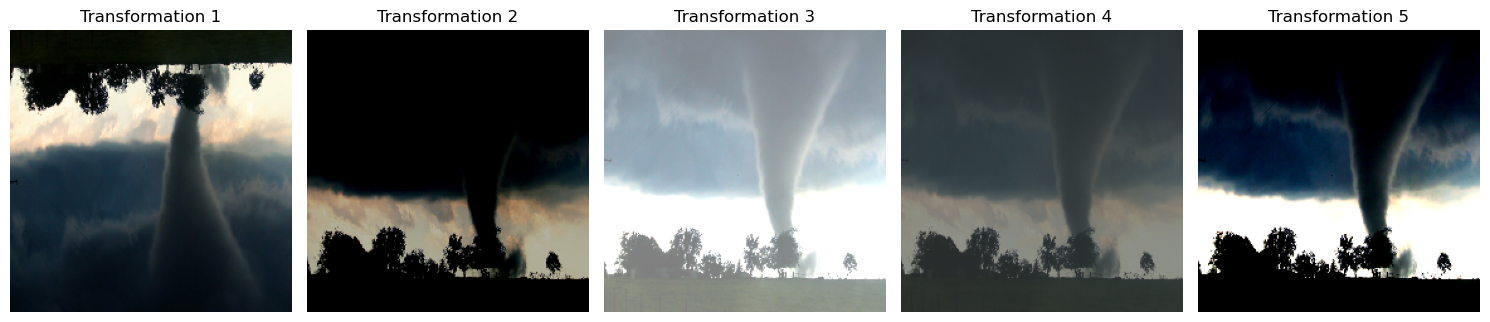

In [33]:
import matplotlib.pyplot as plt

num_samples = 5

plt.figure(figsize=(15, 5))  
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)  
    plt.imshow(augmented_images[i])  
    plt.axis('off')  
    plt.title(f"Transformation {i+1}")

plt.tight_layout()
plt.show()

In [21]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)

In [32]:
tf.shape(X_train)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([15387,   224,   224,     3], dtype=int32)>

### Hyper-parameter Tuning

In [ ]:
def build_model(hp):
    '''
    Builds and compiles the EfficientNetB0-based model with hyperparameter tuning. This method also saves the best parameters and weights during training.

    Args:
        hp (HyperParameters): The hyperparameter object passed by the Keras Tuner during the search.

    Returns:
        model (tf.keras.Model): The compiled Keras model.
    '''
    activation = hp.Choice('activation', ['swish', 'relu'])
    optimizer = hp.Choice('optimizer', ['RMSprop', 'Adam'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.1])

    model = model_EfficientNetB0(INPUT_SHAPE, 13, activation)

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=4,
    seed=RANDOM_STATE,
    project_name='WeatherPhenomena',
)

Reloading Tuner from ./WeatherPhenomena/tuner0.json


In [23]:
tuner.search(X_train, y_train, epochs = 13, validation_data = (X_val, y_val))

In [24]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'activation': 'swish', 'optimizer': 'RMSprop', 'learning_rate': 0.001}

## Final Evaluation

In [25]:
best_hp.values

{'activation': 'swish', 'optimizer': 'RMSprop', 'learning_rate': 0.001}

In [26]:
ACTIVATION_FUNCTION = best_hp.get('activation')         
OPTIMIZER = best_hp.get('optimizer')   
learning_rate = best_hp.get('learning_rate') 

model = model_EfficientNetB0(INPUT_SHAPE, NUM_CLASSES, ACTIVATION_FUNCTION)

if OPTIMIZER == 'adam':
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif OPTIMIZER == 'rmsprop':
    OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(optimizer=OPTIMIZER, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.load_weights('WeatherPhenomena/trial_2/checkpoint.weights.h5')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 215 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.8796 - loss: 0.3767
Validation Loss: 0.3992253839969635
Validation Accuracy: 0.8751444816589355


In [28]:
y_pred = model.predict(x=X_test, batch_size=None, verbose="auto", steps=None, callbacks=None)

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step


In [29]:
y_pred_transformed = np.argmax(y_pred, axis=1)
categorical_labels = le.inverse_transform(y_pred_transformed)
categorical_labels

array(['glaze', 'fogsmog', 'fogsmog', ..., 'rain', 'sandstorm', 'rime'],
      dtype='<U9')

## Visualise results from Test set

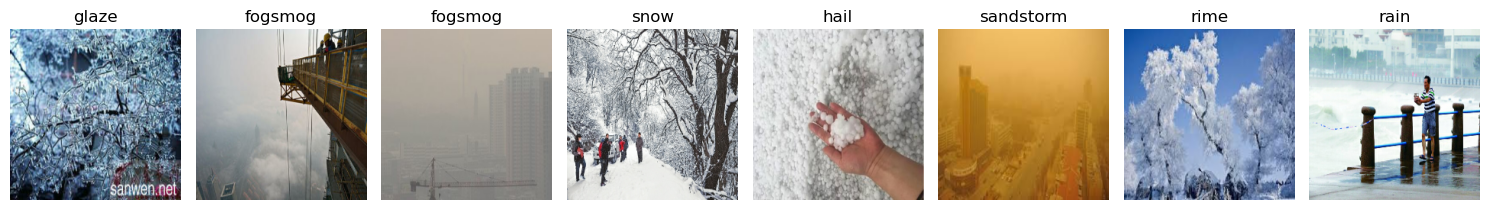

In [31]:
num_samples = 8

plt.figure(figsize=(15, 5))  
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)  
    plt.imshow(X_test[i])  
    plt.axis('off')  
    plt.title(categorical_labels[i])

plt.tight_layout()
plt.show()

In [30]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Test Loss: 0.27220314741134644
Test Accuracy: 0.913948655128479


Save classes encoding

In [36]:
np.save('classes.npy', le.classes_)